<a href="https://colab.research.google.com/github/raneymjohnGit/Austin_TX_House_Listings/blob/jayanbranch/Jayan/Analysis/Front_End_Final-Machine_Learning_Model_Training_with_Pipeline%2C_Column_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to SQL database

In [1]:
# Copy paste this code
# Install psycopg2-binary
! pip install psycopg2-binary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 8.8 MB/s 


In [2]:
# Copy paste this code
# URL for Heroku DB
raw_db_url='dpaclsxjrpfluk:4fa14e6fdb846bd14d1a9eda261d554fab9688f2f4dd5483bc38d94cdee010ad@ec2-3-219-52-220.compute-1.amazonaws.com:5432/d7s0s0hs0a5lar'

In [3]:
 # Copy paste this code
 # Import SQL Alchemy, format url string for SQLAlchemy
 
import subprocess
from sqlalchemy.engine.create import create_engine

# Convert binary string to a regular string & remove the newline character
db_url = raw_db_url

# Convert "postgres://<db_address>"  --> "postgresql+psycopg2://<db_address>" needed for SQLAlchemy
final_db_url = "postgresql+psycopg2://" + db_url.lstrip("postgres://")  # lstrip() is more suitable here than replace() function since we only want to replace postgres at the start!


# Create SQLAlchemy engine
# ------------------------
engine = create_engine(final_db_url)

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in cleaned data from SQL, prepare dataframe

In [5]:
# SQL to dataframe using sqlalchemy
import pandas as pd

df = pd.read_sql_table('cleaned_data_1', engine)
df.head()

,index,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,...,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,month_year,latest_saledate_dt,dec_2019_price,jan_2021_price,price_per_sqft
0,6702,29415933,austin,5804 Bullard Dr,78757,"5804 Bullard Dr, Austin, TX 78757 is a single ...",30.336634,-97.750031,1.98,3,...,1153,16,2.0,3,1,2019-06,2019-06-21,470317,547114,202
1,4729,58304707,austin,823 Walnut Creek Dr,78753,"823 Walnut Creek Dr, Austin, TX 78753 is a sin...",30.386883,-97.668449,1.98,3,...,814,15,2.0,3,1,2019-02,2019-02-27,418299,486603,211
2,7501,29482307,austin,4410 Garnett St,78745,Complete remodel of a gorgeous vintage home. O...,30.218693,-97.770554,1.98,3,...,792,13,2.0,4,1,2019-07,2019-07-02,598560,696298,343
3,5146,29513449,austin,11412 Gun Fight Ln,78748,Large move-in ready Shady Hollow home loaded w...,30.162312,-97.854210,1.98,3,...,1633,17,4.0,5,2,2019-03,2019-03-20,481300,559890,137
4,5256,29479870,austin,1311 Casey St,78745,"1311 Casey St, Austin, TX 78745 is a single fa...",30.225712,-97.781837,1.98,3,...,803,12,2.0,3,1,2019-03,2019-03-11,374344,435470,300


In [6]:
# Drop non-numeric columns that will not be used for models, erroneus columns like index and jan_2021_price, and columns that are calculated from variables like price_per_sqft

df = df.drop(columns=['zpid', 'index', 'city', 'streetAddress', 'description', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'month_year', 'latest_saledate_dt', 'jan_2021_price', 'price_per_sqft', 'homeType', 'latestprice'])


In [7]:
# Cast Zip Code as string for hot encoding

df['zipcode'] = df['zipcode'].astype(str)

In [8]:
# Import all needed dependencies

import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

from sklearn.model_selection import train_test_split # data split
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib

In [9]:
# use only five features needed for front end
df_front_end = df[['zipcode', 'yearBuilt', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolRating','dec_2019_price']]
df_front_end.shape

(8011, 6)

In [10]:
df_front_end.head()

,zipcode,yearBuilt,lotSizeSqFt,livingAreaSqFt,avgSchoolRating,dec_2019_price
0,78757,1958,10018.0,2226.0,6.666667,470317
1,78753,1961,10018.0,1706.0,5.000000,418299
2,78745,1941,15246.0,1676.0,3.333333,598560
3,78748,1988,7361.0,3279.0,7.333333,481300
4,78745,1958,9931.0,1168.0,4.000000,374344


# Train model for front end with pipeline

In [13]:
# Definte features, split into training and testing sets, train model with pipeline

# Define features and target
X = df_front_end.drop(["dec_2019_price"],axis = 1)
y = df_front_end.dec_2019_price

# Load and save column transformer to hote encode zip code
ct = ColumnTransformer([("cat", OneHotEncoder(handle_unknown = "ignore"),[0])], remainder="passthrough")
rf_model = RandomForestRegressor()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Wrap the randomforestregressor into a model with the hot encoding pipeline. Train the model.
model = Pipeline([("preprocessing",ct),("model",rf_model)]).fit(X_train,y_train)

# Score/test the model
Pipeline([("preprocessing",ct),("model",rf_model)]).score(X_test,y_test)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


0.7009204123967103

# Hypertune with grid search on model with pipeline

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
X = df_front_end.drop(["dec_2019_price"],axis = 1)
y = df_front_end.dec_2019_price
ct = ColumnTransformer([("cat", OneHotEncoder(handle_unknown = "ignore"),[0])], remainder="passthrough")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=100, n_jobs = -1)
# Fit the random search model
model = Pipeline([("preprocessing",ct),("model",rf_random)]).fit(X_train,y_train)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores



Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# View best parameters from grid search
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [ ]:
# Save hypertuned model from grid search
best_random = rf_random.best_estimator_

In [ ]:
# Train hypertuned model
best_random.fit(X_train, y_train)

# Test/score hypertuned model
best_random.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


0.7180980500799892

# Export Model for Front End

In [ ]:
# loading joblib dependency
import joblib

# save best_random model for front end
# joblib.dump(best_random, '/content/drive/MyDrive/MachineLearningModels/rf_front_end_final-model_jlib')

# Test model, visualize performance

In [12]:
# load model from google drive

loaded_model = joblib.load('/content/drive/MyDrive/MachineLearningModels/rf_front_end_final-model_jlib')

In [14]:
# Generate features and target

X = df_front_end.drop(["dec_2019_price"],axis = 1)
y = df_front_end.dec_2019_price

In [15]:
# Generate predictions, conver to list to inspect
y_pred = loaded_model.predict(X)
list1 = y_pred.tolist()
list1[0:4]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


[561025.3489987385, 339764.1069840478, 475833.416648035, 479767.403524158]

In [16]:
# Make a copy of original data, load predictions into dataframe to join

df_copy = df_front_end.copy()
df_predictions = pd.DataFrame({'predictions':list1})
df_predictions

,predictions
0,561025.348999
1,339764.106984
2,475833.416648
3,479767.403524
4,351446.462279
...,...
8006,283586.402097
8007,688594.411655
8008,572526.931476
8009,394828.137590


In [17]:
# Join dataframes to see predictions next to true value

df_joined = df_copy.join(df_predictions)
df_joined.head()

,zipcode,yearBuilt,lotSizeSqFt,livingAreaSqFt,avgSchoolRating,dec_2019_price,predictions
0,78757,1958,10018.0,2226.0,6.666667,470317,561025.348999
1,78753,1961,10018.0,1706.0,5.000000,418299,339764.106984
2,78745,1941,15246.0,1676.0,3.333333,598560,475833.416648
3,78748,1988,7361.0,3279.0,7.333333,481300,479767.403524
4,78745,1958,9931.0,1168.0,4.000000,374344,351446.462279


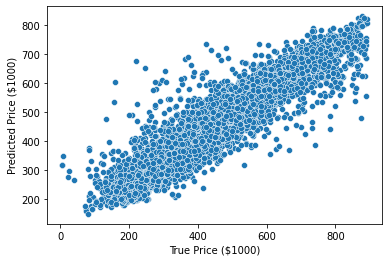

In [18]:
# Plot predictions against true value

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
x_1000 = df_joined['dec_2019_price']/1e3
y_1000 = df_joined['predictions']/1e3

p = sns.scatterplot(x = x_1000, y = y_1000)
p.set_ylabel(ylabel = "Predicted Price ($1000)")
p.set_xlabel(xlabel= "True Price ($1000)")
sns.set(rc = {'figure.figsize':(15,10)})
plt.show()

Text(0, 0.5, 'Frequency')

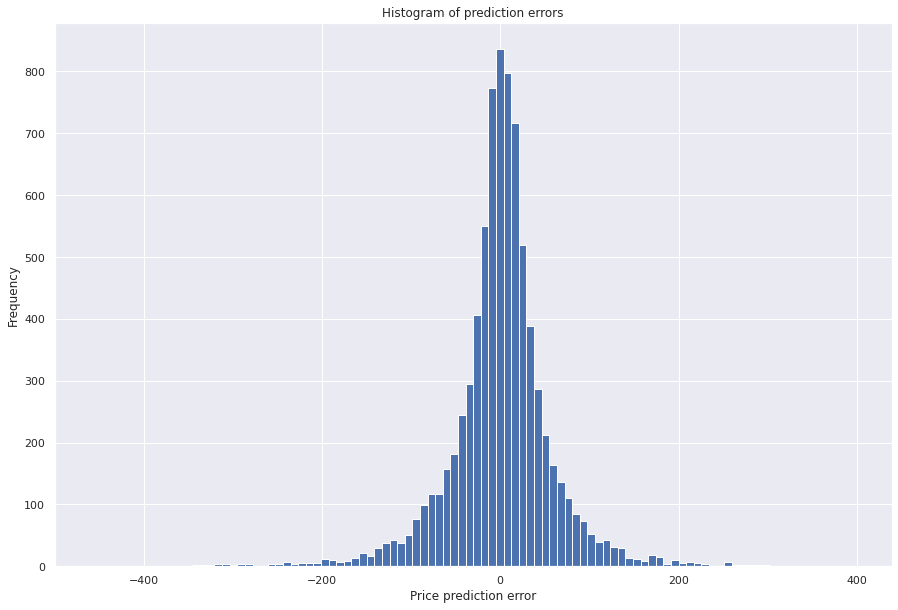

In [19]:
# Plot prediction errors

diff = df_joined['dec_2019_price']/1e3 - df_joined['predictions']/1e3
diff.hist(bins = 100)
plt.title('Histogram of prediction errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')

# Use Yellowbrick to further visualize performance

In [20]:
pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


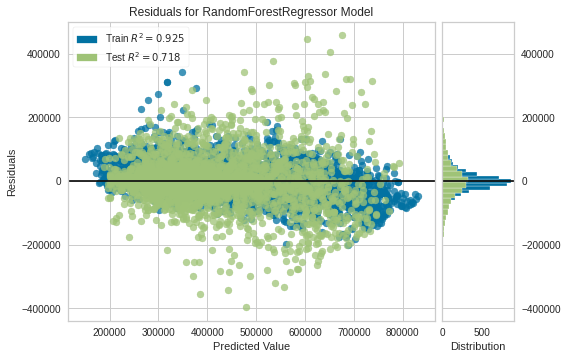

In [21]:
# Wrap model with yellowbrick residuals plot visualizer
sns.set(rc = {'figure.figsize':(10,7.5)})
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(loaded_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


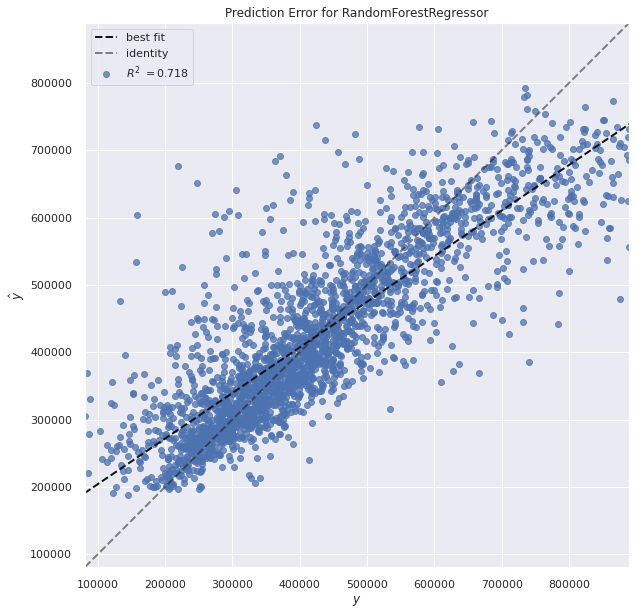

In [ ]:
# Wrap model with yellowbrick prediction error visualizer

from yellowbrick.regressor import prediction_error
visualizer = prediction_error(loaded_model, X_train, y_train, X_test, y_test)

In [ ]:
# Double checking score matches yellowbrick

loaded_model.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


0.7180980500799892

In [24]:
# Predicting the Test set results
y_pred = loaded_model.predict(X_test)

# Evaluating the Algorithm
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


Mean Absolute Error: 59232.02483311126
Mean Squared Error: 7343080730.851085
Root Mean Squared Error: 85691.77749849214
